In [1]:
import tensorflow as tf
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from PIL import Image
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc

2025-04-30 18:45:04.649658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 18:45:04.670871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746038704.696140  688272 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746038704.704595  688272 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746038704.724121  688272 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### From HuggingFace to generate caption

In [13]:
model_id = "google/paligemma2-10b-mix-224"
dtype = torch.bfloat16

if torch.cuda.is_available():
    torch.cuda.set_device(1)  # Set current device to 1
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
).eval()
processor = AutoProcessor.from_pretrained(model_id)

# Instruct the model to create a caption in Spanish
prompt = "<image>What is this?"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)


Using device: cuda:1


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

a hate symbol


In [14]:
torch.cuda.empty_cache()
gc.collect()

143

In [ ]:
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map={"": device}  # map model to cuda:0
).eval()

processor = AutoProcessor.from_pretrained(model_id)

# # Load a simple HF dataset small image dataset of beans 
# dataset = load_dataset("beans", split="train")  # tiny dataset, simple images
# dataset = dataset.shuffle(seed=42).select(range(100))  # only 100 samples


# Load ImageNet-1k from Huggingface
dataset = load_dataset("imagenet-1k", split="train")

# Shuffle and select only a subset
dataset = dataset.shuffle(seed=42).select(range(500))  # Only 500 images


# Set up activation capture (vision tower)
vision_acts = {}

def vision_hook(module, input, output):
    vision_acts["activation"] = output

# hook_handle = model.vision_tower.vision_model.encoder.layers[0].register_forward_hook(vision_hook)
hook_handle = model.vision_tower.vision_model.encoder.layers[20].register_forward_hook(vision_hook)

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


In [ ]:
activation_list = []
image_to_token_counts = []

for example in tqdm(dataset):
    try:
        image = example["image"]
        prompt = "<image> caption"  # critical: add <image> token

        # Prepare input
        model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
        input_len = model_inputs["input_ids"].shape[-1]

        with torch.no_grad():
            _ = model.generate(**model_inputs, max_new_tokens=5, do_sample=False)

        # Get and store activation
        act = vision_acts["activation"]
        if isinstance(act, tuple):
            act = act[0]
        activation_list.append(act.squeeze(0).cpu().float())

        image_to_token_counts.append(act.shape[1])  # act: (batch=1, seq_len, hidden_dim)

    except Exception as e:
        print(f"Skipping sample due to error: {e}")
        continue

# remove hook after collection
hook_handle.remove()

if len(activation_list) == 0:
    raise ValueError("No valid activations collected!")

all_activations = torch.cat(activation_list, dim=0)  # (tokens, hidden_dim)
print("Collected activations:", all_activations.shape)

print("Sum of tokens recorded:", sum(image_to_token_counts))

In [37]:
class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=768, d_hidden=4096):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

In [38]:
# Match SAE dimension to collected activation
d_in = all_activations.shape[-1]

sae = SparseAutoencoder(d_in=d_in, d_hidden=4*d_in).to(device)

optimizer = torch.optim.AdamW(sae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
n_epochs = 10
batch_size = 512

train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    for batch, in train_loader:
        batch = batch.to(device)
        recon, z = sae(batch)
        loss = loss_fn(recon, batch) + 1e-4 * torch.mean(torch.abs(z))  # MSE + sparsity

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss {loss.item():.6f}")

print("Finished training Sparse Autoencoder!")

# (Optional) Save the trained SAE model
# torch.save(sae.state_dict(), "trained_sae.pth")
# print("Saved SAE to trained_sae.pth")

Epoch 1: Loss 0.378992
Epoch 2: Loss 0.225590
Epoch 3: Loss 0.170291
Epoch 4: Loss 0.126564
Epoch 5: Loss 0.096699
Epoch 6: Loss 0.078615
Epoch 7: Loss 0.082696
Epoch 8: Loss 0.053965
Epoch 9: Loss 0.064432
Epoch 10: Loss 0.047645
Finished training Sparse Autoencoder!


Sparse feature shape: torch.Size([25600, 4608])
Top 5 most 'active' SAE features: [4347, 744, 3267, 559, 698]


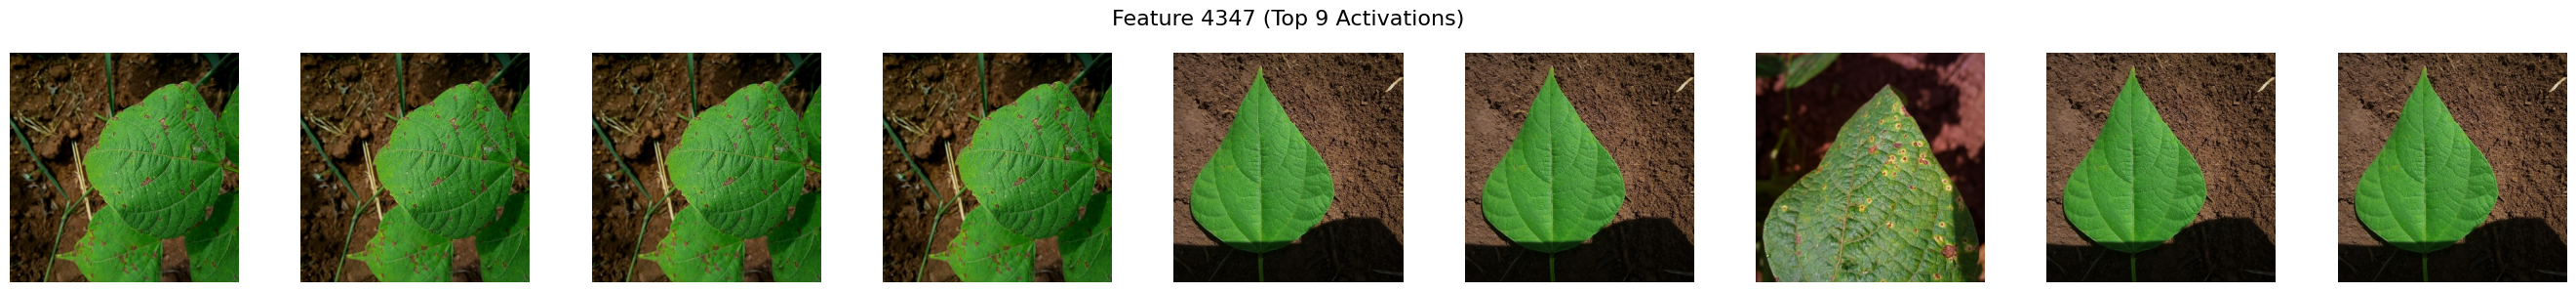

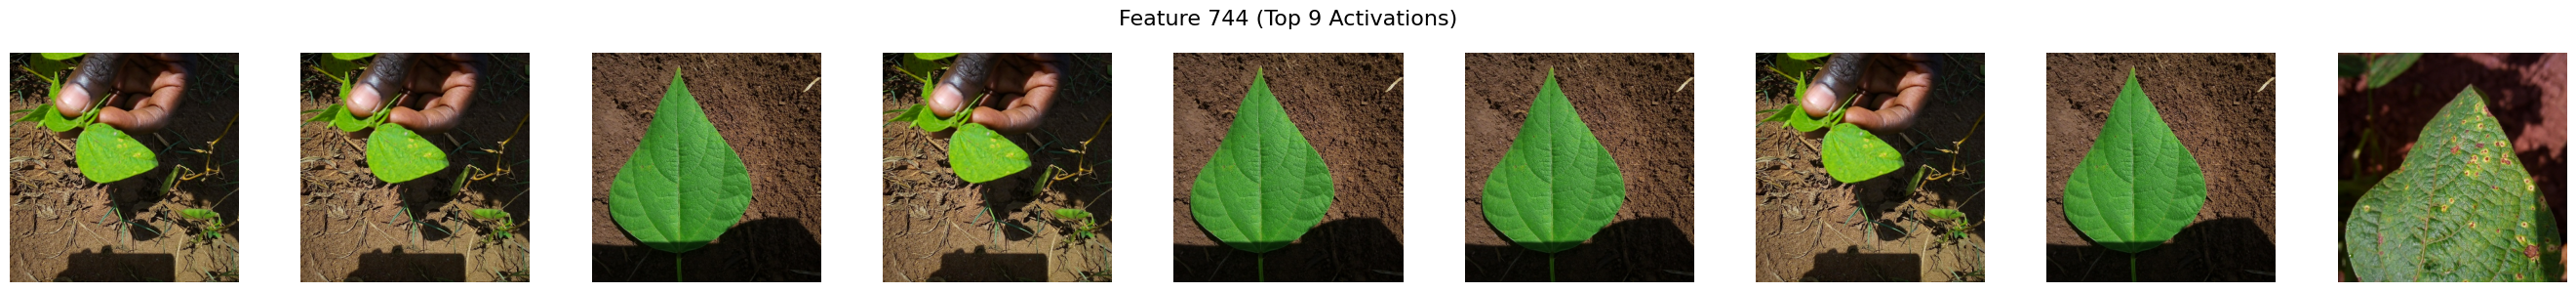

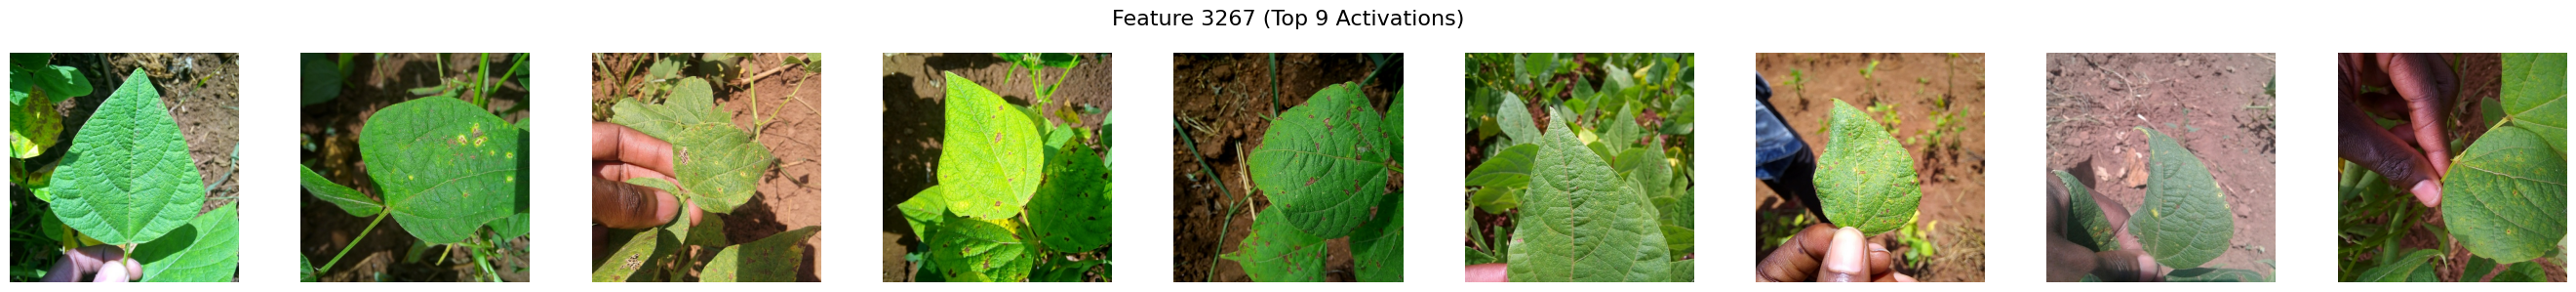

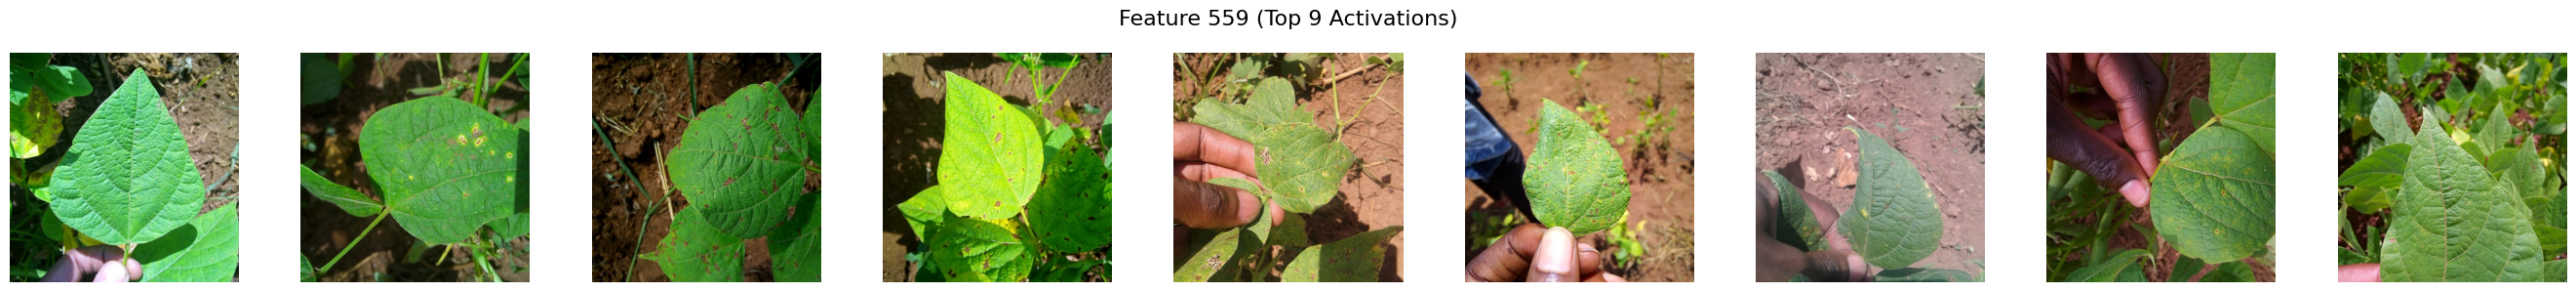

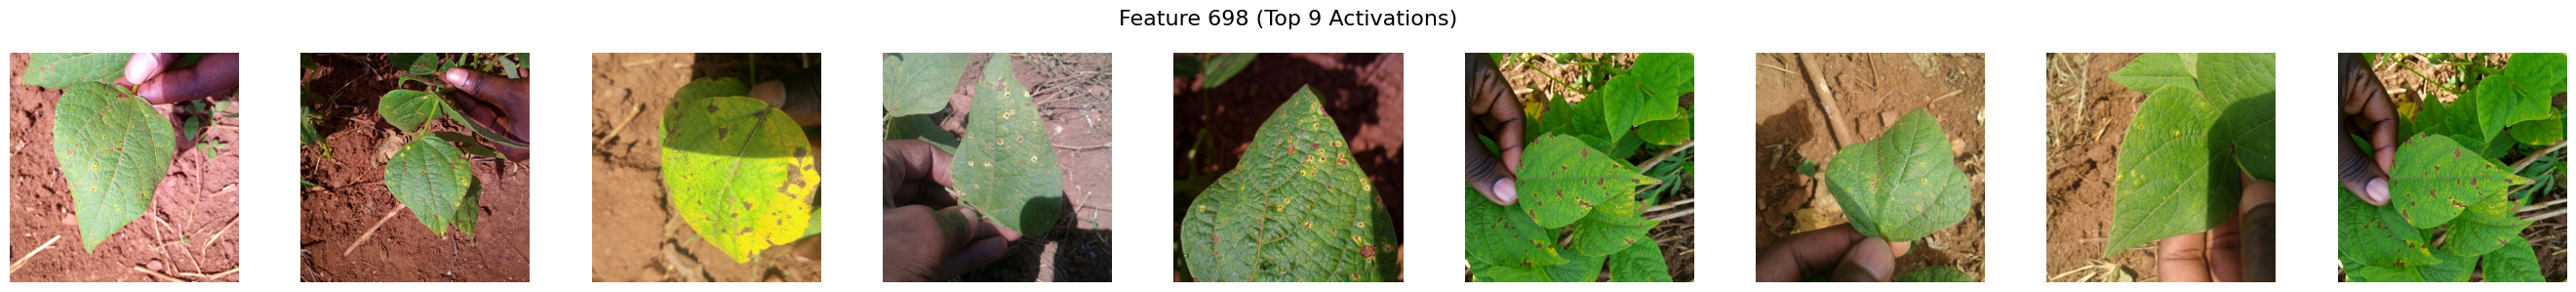

In [39]:
# encode activations to get sparse features
with torch.no_grad():
    sparse_features = sae.activation(sae.encoder(all_activations.to(sae.encoder.weight.device)))

print("Sparse feature shape:", sparse_features.shape)

# Reconstruct the token-to-image mapping
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)

assert len(image_indices_per_token) == sparse_features.shape[0], \
    f"Length mismatch: got {len(image_indices_per_token)} tokens but {sparse_features.shape[0]} sparse rows"

image_indices_per_token = np.array(image_indices_per_token)

# find top features
n_features_to_plot = 5
top_features = torch.topk(sparse_features.mean(dim=0), k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} most 'active' SAE features:", top_features)

# visualize the top-k activating images for each feature
top_k = 9

for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().numpy()

    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 3))
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=16)

    for ax, idx in zip(axes, topk_indices):
        img_idx = int(image_indices_per_token[idx])  # 🛠️ FIXED: cast to Python int
        image = dataset[img_idx]["image"]
        ax.imshow(np.array(image))
        ax.axis("off")

    plt.tight_layout()
    plt.show()